## TSMD Course Project: Analysis of Aircraft Flight Data
### Author: MIRKO NARDI

### PART 2 - Time series analysis

In this section, we focus on the Time Series part of the course. \
The primary focus will be on the **clustering** and **classification** of flight route trajectories, continuing to utilize the OpenSky dataset introduced in PART 1.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import requests
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

import skmob
from skmob.utils.plot import plot_gdf

from shapely.geometry import box

from zz_utils import *

/home/mirko/miniforge3/envs/timeser3/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


### Data Download 
The following cells are for downloading the data and will be **skipped**. \
If you are interested in this step
- remove the %%script macro. 
- CAUTION: it downloads and extracts a lot of data

Otherwise, you can skip directly to the section on reading the zipped file.

In [3]:
%%script echo skipping

# TO DOWNLOAD ALL THE FILES
base_url = 'https://opensky-network.org/datasets/states/'

# start = "2020-05-25"; end = "2022-06-28"  # take all the data available 
start = "2021"; end = "2022"              # take only the year 2021
#start = "2021-01-25"; end = start           # take one day 

list_days = pd.date_range(start =start, end=end, freq="W-MON").strftime('%Y-%m-%d').tolist()
list_subdir = ['%02d' % i for i in range(24)] # 00 to 23

# Folder to download files to
download_path = 'opensky_data' 

for day in list_days:
    for subdir in list_subdir:
        url = base_url + day + '/' + subdir + '/'
        print("Starting: " + url)

        # CAUTION: This will download a lot of data. 
        # Note, some days have missing hours in the data
        download_files(url, download_path) 
        
        # CAUTION: This will extract a lot of data.
        extract_files(download_path)


skipping


In [4]:
%%script echo skipping

#filter = '2021'
#filter = '2021-01' 
# take one day
filter = '2021-01-25' 

download_path = 'opensky_data' 
# read downloaded files
all_files = glob.glob(os.path.join(download_path, "*.csv.gz"))
all_files = [f for f in all_files if filter in f]
all_files.sort()
all_files # VERIFY IF MISSING HOURS

skipping


In [5]:
%%script echo skipping

# Read all first and then concat is faster - require more memory
df_list = []
for f in all_files:
    print(f)
    #df_temp = pd.read_csv(f,engine='c', low_memory=False)
    df_temp = pd.read_csv(f,engine='pyarrow') # pip install pyarrow
    # drop column now to save memory
    df_list.append(df_temp)
df = pd.concat(df_list, ignore_index=True) 
#df.to_parquet('opensky_data/cached/opensky_data_saved.gzip', compression='gzip') # cache the data
# add filter to filename
df.to_parquet(f'opensky_data/cached/opensky_data_saved_{filter}.gzip', compression='gzip') # cache the data

skipping


<a id="read_ready"></a>

### Read one day of data
- Even just one day is already very big: ~3.2 GB in memory - ~0.9 GB on disk (compressed)
- The data is wordlwide 


In [6]:
# read cached data (raw) 
filter = '2021-01-25' 
df_raw = pd.read_parquet(f'opensky_data/cached/opensky_data_saved_{filter}.gzip') 

In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30639993 entries, 0 to 30639992
Data columns (total 16 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time           int64  
 1   icao24         object 
 2   lat            float64
 3   lon            float64
 4   velocity       float64
 5   heading        float64
 6   vertrate       float64
 7   callsign       object 
 8   onground       bool   
 9   alert          bool   
 10  spi            bool   
 11  squawk         float64
 12  baroaltitude   float64
 13  geoaltitude    float64
 14  lastposupdate  float64
 15  lastcontact    float64
dtypes: bool(3), float64(10), int64(1), object(2)
memory usage: 3.1+ GB


In [8]:
# some preprocessing
def preprocess(df1):
    df = df1.copy()
    df = df.drop(columns=[ 'lastcontact', 'squawk', 'alert', 'spi'], errors='ignore') # drop unnecessary columns
    df['icao24'] = df['icao24'].str.strip()
    df['callsign'] = df['callsign'].str.strip()
    df['velocity'] = df['velocity'] * 3.6 # convert to km/h for more familiar units
    
    df['lastposupdate'] = pd.to_datetime(df['lastposupdate'], unit='s')
    df['time'] = pd.to_datetime(df['time'], unit='s')
    
    df = df.sort_values(by='time').reset_index(drop=True)

    # not now
    #df['datetime'] = df['time']
    #df['datetime'] = df['lastposupdate']
    
    # move lastposupdate at the beginning (close to time)
    cols =  ['time','lastposupdate'] + [col for col in df if col not in ['time','lastposupdate']]
    df = df[cols]

    return df


In [9]:
# Restart HERE - avoid reading the raw data again 
df = df_raw.copy()

### Filtering for European Flight Trajectories

To find similar trajectories to work on, we will narrow down the dataset to include only flight routes within Europe. 
- This region is densely populated with flights 
- The flights typically last a few hours, ensuring they do not extend into the next day 

In [10]:
# Europe borders (approximate)
west_long = -31.266001
east_long = 39.869301
north_lat = 71.185474
south_lat = 34.5428

# plot borders 
eu_box = gpd.GeoDataFrame(geometry=[box(west_long, south_lat, east_long, north_lat)])
plot_gdf(eu_box, zoom = 3)

In [11]:
# check if coordinates are within Europe
# Even if one point is outside Europe, the trajectory is considered outside Europe

# Use vectorized operations for faster processing
lat = df['lat'].values
lon = df['lon'].values

# Create a boolean mask for coordinates within Europe. 
in_europe_mask = (
    ((lat >= south_lat) & (lat <= north_lat) & 
    (lon >= west_long) & (lon <= east_long)) | 
    np.isnan(lat) # NaNs coords are considered in Europe -  NaN outside in europe will be excluded later
)

df['in_europe'] = in_europe_mask

# find all icao24 NOT in europe
non_europe_aircraft = df[~df['in_europe']]['icao24'].unique()

# all minus non_europe - Note that NaN outside in europe will be excluded 
europe_aircraft = np.setdiff1d(df['icao24'].unique(), non_europe_aircraft)
europe_aircraft

array(['000000', '000003', '000017', ..., 'fdac98', 'fff000', 'fffffe'],
      dtype=object)

In [12]:
europe_aircraft
df_select = df[df['icao24'].isin(europe_aircraft)]
df_select = preprocess(df_select)

In [13]:
df_select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6658224 entries, 0 to 6658223
Data columns (total 13 columns):
 #   Column         Dtype         
---  ------         -----         
 0   time           datetime64[ns]
 1   lastposupdate  datetime64[ns]
 2   icao24         object        
 3   lat            float64       
 4   lon            float64       
 5   velocity       float64       
 6   heading        float64       
 7   vertrate       float64       
 8   callsign       object        
 9   onground       bool          
 10  baroaltitude   float64       
 11  geoaltitude    float64       
 12  in_europe      bool          
dtypes: bool(2), datetime64[ns](2), float64(7), object(2)
memory usage: 571.5+ MB


In [14]:
# check one aircraft in one day 
df_select[df_select['icao24'] == '4d227b']

,time,lastposupdate,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,baroaltitude,geoaltitude,in_europe
699047,2021-01-25 04:37:10,2021-01-25 04:37:08.004000000,4d227b,44.569530,26.089832,NaN,NaN,NaN,,True,NaN,NaN,True
699622,2021-01-25 04:37:20,2021-01-25 04:37:19.522000128,4d227b,44.569485,26.089230,NaN,NaN,NaN,,True,NaN,NaN,True
700069,2021-01-25 04:37:30,2021-01-25 04:37:28.865999872,4d227b,44.569450,26.088811,NaN,NaN,NaN,,True,NaN,NaN,True
700722,2021-01-25 04:37:40,2021-01-25 04:37:38.256000000,4d227b,44.569427,26.088442,NaN,NaN,NaN,RYR4NN,True,NaN,NaN,True
701069,2021-01-25 04:37:50,2021-01-25 04:37:49.615000064,4d227b,44.569382,26.087952,NaN,NaN,NaN,RYR4NN,True,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937038,2021-01-25 11:38:50,2021-01-25 11:34:24.586999808,4d227b,44.569625,26.091190,204.735889,264.289407,-0.32512,RYR9K,False,NaN,NaN,True
2938309,2021-01-25 11:39:00,2021-01-25 11:34:24.586999808,4d227b,44.569625,26.091190,204.735889,264.289407,-0.32512,RYR9K,False,NaN,NaN,True
2939104,2021-01-25 11:39:10,2021-01-25 11:34:24.586999808,4d227b,44.569625,26.091190,204.735889,264.289407,-0.32512,RYR9K,False,NaN,NaN,True
2940349,2021-01-25 11:39:20,2021-01-25 11:34:24.586999808,4d227b,44.569625,26.091190,204.735889,264.289407,-0.32512,RYR9K,False,NaN,NaN,True


### Handle missing values
We do the same fill as previous notebook with NaN values in **lat** and **lon** and **lastposupdate**



In [15]:
#df_select = df[df['icao24'].isin(europe_aircraft)] # rebuild df_select for different tests
#df_select = preprocess(df_select)

def interpolate(group):
    # if all NaN lat, drop the group
    if group['lat'].isna().all():
        return group.dropna() # return empty dataframe

    # interpolate 'holes' in the data
    group['lat_repair'] = group['lat'].interpolate(method='linear')
    group['lon_repair'] = group['lon'].interpolate(method='linear')

    # remaining NaN are at the beginning of the group
    group['lat_repair'] = group['lat_repair'].fillna(method='bfill')
    group['lon_repair'] = group['lon_repair'].fillna(method='bfill')

    # Repairing NaN lastposupdate with time is a good approximation
    group['lastposupdate_repair'] = group['lastposupdate'].fillna(group['time'])
    
    # repairing empty '' callsign with the last known callsign
    group.loc[:, 'callsign_repair'] = group['callsign'].replace('', method='bfill') 
    # Remaining callsign can be ffilled with the first known callsign
    group.loc[:, 'callsign_repair'] = group['callsign_repair'].replace('', method='ffill')

    return group

dd = df_select.groupby('icao24').apply(interpolate)
df_select = pd.concat([dd], ignore_index=True).sort_values(by=['time']).reset_index(drop=True)

# remove groups of callrepair with number of rows too low 
df_select = df_select.groupby('callsign_repair').filter(lambda x: len(x) > 200)

In [16]:
df_select

,time,lastposupdate,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,baroaltitude,geoaltitude,in_europe,lat_repair,lon_repair,lastposupdate_repair,callsign_repair
0,2021-01-25 00:00:00,2021-01-24 23:59:58.959000064,4404bd,49.623149,9.756527,914.797230,108.655034,0.00000,TAY4081,False,11277.60,NaN,True,49.623149,9.756527,2021-01-24 23:59:58.959000064,TAY4081
1,2021-01-25 00:00:00,2021-01-24 23:59:58.503000064,4bcc66,50.151005,9.455072,884.481940,118.926426,9.42848,THY2YT,False,11369.04,10797.54,True,50.151005,9.455072,2021-01-24 23:59:58.503000064,THY2YT
3,2021-01-25 00:00:10,2021-01-25 00:00:04.420000000,448184,50.910793,4.496637,NaN,NaN,NaN,WINT092,True,NaN,NaN,True,50.910793,4.496637,2021-01-25 00:00:04.420000000,WINT092
4,2021-01-25 00:00:10,2021-01-25 00:00:09.349999872,5113fb,59.409663,24.827184,NaN,NaN,NaN,TXLU01,True,NaN,NaN,True,59.409663,24.827184,2021-01-25 00:00:09.349999872,TXLU01
5,2021-01-25 00:00:10,2021-01-25 00:00:09.691000064,4403f4,44.668167,5.193917,857.637244,178.886399,-5.20192,TAY4857,False,8214.36,NaN,True,44.668167,5.193917,2021-01-25 00:00:09.691000064,TAY4857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4113268,2021-01-25 23:59:50,2021-01-25 23:59:48.173000192,343654,40.496955,-3.563612,NaN,NaN,NaN,P3,True,NaN,NaN,True,40.496955,-3.563612,2021-01-25 23:59:48.173000192,P3
4113271,2021-01-25 23:59:50,NaT,342349,NaN,NaN,NaN,NaN,NaN,TXLU05,False,NaN,NaN,True,40.497793,-3.557854,2021-01-25 23:59:50.000000000,TXLU05
4113272,2021-01-25 23:59:50,2021-01-25 23:59:49.675000064,484201,52.313118,4.743748,NaN,NaN,NaN,C2,True,NaN,NaN,True,52.313118,4.743748,2021-01-25 23:59:49.675000064,C2
4113273,2021-01-25 23:59:50,2021-01-25 23:57:27.713999872,4b1809,47.450397,8.559740,NaN,NaN,NaN,SWR150Y,True,NaN,NaN,True,47.450397,8.559740,2021-01-25 23:57:27.713999872,SWR150Y


### Identifying Start and Stop Cities for Each Flight

Now that we have filtered the dataset to include only trajectories within Europe, we will identify the start and stop cities for each flight. \
To achieve this, we will use the callsign and the closest distance to the airport. 

NOTE: this is a simplification 
- Callsign values appear to be unreliable and may yield incorrect results for some flights.
    - the trajectory stop detection process  is more reliable (we covered in PART 1) 
- We now use it since it is computationally lighter 


In [17]:
# get all the airports
airports_url = 'https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat'
airports_columns = ['Airport_ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz_database_time_zone', 'Type', 'Source']
airports_columns = [col.lower() for col in airports_columns]
airports = pd.read_csv(airports_url, names=airports_columns)
airports
# convert to geodataframe
gdf_airports = gpd.GeoDataFrame(airports, geometry=gpd.points_from_xy(airports['longitude'], airports['latitude'])) # inverse lat lon
gdf_airports

,airport_id,name,city,country,iata,icao,latitude,longitude,altitude,timezone,dst,tz_database_time_zone,type,source,geometry
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports,POINT (145.39200 -6.08169)
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports,POINT (145.78900 -5.20708)
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports,POINT (144.29601 -5.82679)
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports,POINT (146.72598 -6.56980)
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports,POINT (147.22000 -9.44338)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7693,14106,Rogachyovo Air Base,Belaya,Russia,\N,ULDA,71.616699,52.478298,272,\N,\N,\N,airport,OurAirports,POINT (52.47830 71.61670)
7694,14107,Ulan-Ude East Airport,Ulan Ude,Russia,\N,XIUW,51.849998,107.737999,1670,\N,\N,\N,airport,OurAirports,POINT (107.73800 51.85000)
7695,14108,Krechevitsy Air Base,Novgorod,Russia,\N,ULLK,58.625000,31.385000,85,\N,\N,\N,airport,OurAirports,POINT (31.38500 58.62500)
7696,14109,Desierto de Atacama Airport,Copiapo,Chile,CPO,SCAT,-27.261200,-70.779198,670,\N,\N,\N,airport,OurAirports,POINT (-70.77920 -27.26120)


In [18]:
from shapely.geometry import Point

# function to calculate the distance between a row and all the airports
def min_distance(row, gdf_airports, suffix='end'):
    point = Point(row['lon_repair'], row['lat_repair'])
    distances = gdf_airports.distance(point)
    min = distances.min()
    min_index = distances.argmin()
    ret = pd.Series({
        # city + suffix
        'city_' + suffix: gdf_airports.iloc[min_index]['city'],
    })
    ret['dist_near'] = min

    return ret

# function to calculate the start and end airports of a group
def start_end(group):
    # if less than 2 rows, return empty
    if len(group) < 100:
        #print('less than 100')
        return None
    # take the first and last row of the group
    first = group.iloc[0]
    last = group.iloc[-1]
    # apply the min_distance function to the first and last row
    first = min_distance(first, gdf_airports, 'start')
    last = min_distance(last, gdf_airports,'end')
    # return the first and last row
    return pd.concat([first, last])



In [19]:
df_r = df_select.groupby('callsign').apply(start_end).reset_index()

#df_r = df_select.groupby('callsign_repair').apply(start_end).reset_index()
#df_r = df_r.rename(columns={'callsign_repair': 'callsign'})

# drop NaN rows
df_r = df_r.dropna()

# drop start and end equal - some aircraft flight around the airport
df_r = df_r[df_r['city_start'] != df_r['city_end']]

# concatenate columns start end with - 
df_r['route'] = df_r['city_start'] + '-' + df_r['city_end']

# remove columns city_start and city_end and dist_near
df_r = df_r.drop(columns=['city_start', 'city_end', 'dist_near'])
df_r

,callsign,route
4,2FLYT,Nice-Cuneo
8,5ADCN,Rome-Lampedusa
11,7TVNF,Algier-Bou Saada
13,9ADWA,Bologna-Vienna
19,AAB157,Kortrijk-vevelgem-Brussels
...,...,...
5443,YUPZM,Belgrade-Kiev
5444,YURDA,Belgrade-Osijek
5445,YUSPB,Belgrade-Moscow
5446,Z3MKD,Sarajevo-Brussels


In [20]:
route_counts = df_r['route'].value_counts().reset_index()
route_counts.columns = ['route', 'count']

# Add a column with the list of callsigns for each route
#route_counts['callsigns'] = route_counts['route'].apply(lambda x: df_r[df_r['route'] == x]['callsign_repair'].tolist())
route_counts['callsigns'] = route_counts['route'].apply(lambda x: df_r[df_r['route'] == x]['callsign'].tolist())
# again but inside ""
route_counts['callsigns'] = route_counts['callsigns'].apply(lambda x: ', '.join(['"'+str(i)+'"' for i in x]))
route_counts.head(10)


,route,count,callsigns
0,Nevsehir-Istanbul,46,"""PGT2097"", ""PGT2135"", ""PGT2423"", ""PGT2741"", ""P..."
1,Istanbul-Kayseri,39,"""IAW224"", ""KAC152"", ""KAC156"", ""PGT130"", ""PGT23..."
2,Istanbul-Nevsehir,34,"""PGT19R"", ""PGT2386"", ""PGT2406"", ""PGT2410"", ""PG..."
3,Sinop-Istanbul,32,"""AHY175"", ""MNB6563"", ""MNB6565"", ""PGT19G"", ""PGT..."
4,Kayseri-Istanbul,29,"""IAW223"", ""KAC151"", ""KAC155"", ""PGT2373"", ""PGT3..."
5,Tokat-Istanbul,22,"""IRB9700"", ""IRC512"", ""IRM112"", ""PGT131"", ""PGT2..."
6,Istanbul-Tokat,20,"""IRC513"", ""IRM113"", ""PGT2554"", ""PGT2580"", ""PGT..."
7,Merzifon-Istanbul,20,"""PGT13L"", ""PGT13P"", ""PGT18L"", ""PGT2505"", ""PGT2..."
8,Izmir-Istanbul,18,"""GPGT38L"", ""PGT2207"", ""PGT3300"", ""PGT3304"", ""P..."
9,Istanbul-Ankara,18,"""PGT4302"", ""PGT82G"", ""PGT85H"", ""PGT87A"", ""SXS0..."


In [21]:
# select the top n routes with the most flights - convert to dict for later 
num_routes = 6 # CHANGE HERE for more routes

route_counts = route_counts.head(num_routes)
route_counts['callsigns'].values
# create a dictionary with the routes and callsigns
route_dict = dict(zip(route_counts['route'], route_counts['callsigns']))
route_dict
# 

{'Nevsehir-Istanbul': '"PGT2097", "PGT2135", "PGT2423", "PGT2741", "PGT2743", "PGT29G", "PGT38N", "PGT4381", "PGT45J", "PGT48P", "PGT50Y", "PGT60H", "PGT77F", "PGT89G", "PGT89P", "PGT93J", "PGT95M", "THY1RQ", "THY2205", "THY2PM", "THY2VP", "THY31W", "THY3CS", "THY3YV", "THY41V", "THY47E", "THY4GU", "THY4YR", "THY5BP", "THY5PR", "THY6EQ", "THY6SP", "THY6VB", "THY7217", "THY7319", "THY7KN", "THY7LX", "THY7SP", "THY80V", "THY88B", "THY8RJ", "THY9DN", "THY9JS", "THY9PQ", "THY9WU", "THY9YF"',
 'Istanbul-Kayseri': '"IAW224", "KAC152", "KAC156", "PGT130", "PGT2372", "PGT2384", "PGT2422", "PGT2574", "PGT53B", "PGT61K", "PGT66T", "PGT72J", "PGT74Q", "PGT77J", "PGT84Y", "PGT85J", "PGT87T", "THY1CB", "THY1HP", "THY1PX", "THY1WV", "THY2246", "THY2WS", "THY38HA", "THY3SU", "THY3VU", "THY3YD", "THY3YK", "THY44W", "THY4BK", "THY54", "THY5EK", "THY5LP", "THY61Y", "THY6446", "THY6BK", "THY7ZB", "THY8XT", "THY9MB"',
 'Istanbul-Nevsehir': '"PGT19R", "PGT2386", "PGT2406", "PGT2410", "PGT24N", "PGT2732", "

PGT60H


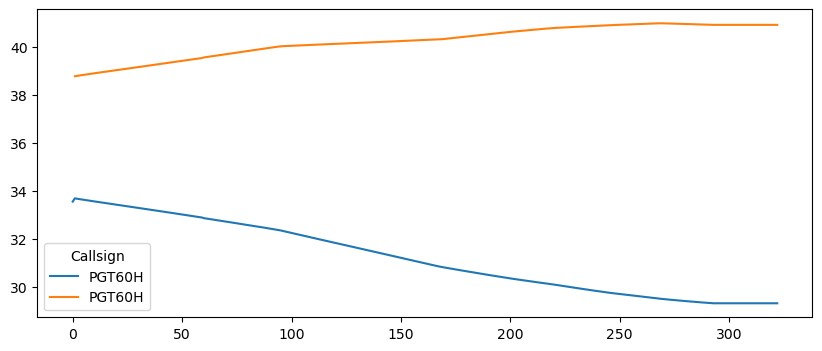

In [22]:
import matplotlib.pyplot as plt
ng = [(name,group) for name, group in df_select.groupby('callsign_repair')]
ng = [(name,group) for name, group in ng if name in ["PGT60H"]]
fig, ax = plt.subplots()
for name, group in ng[:]:
    print(name)
    group = group.reset_index(drop=False)
    
    group.plot(y='lon_repair', ax=ax, figsize=(10, 4), label=name)
    group.plot(y='lat', ax=ax, figsize=(10, 4), label=name)

    # Display the legend
ax.legend(title='Callsign')

plt.show()

In [23]:
# Create a new column 'route', and filter only the top route trajectory selected 

df_select_top = df_select.copy()
df_select_top['route'] = np.nan

for route, callsigns in route_dict.items():
    callsign_list = [cs.strip().replace('"', '') for cs in callsigns.split(',')]
    # Update the 'route' column for rows with matching callsigns
    df_select_top.loc[df_select_top['callsign_repair'].isin(callsign_list), 'route'] = route # TODO ERA COSI
    #df_select_top.loc[df_select_top['callsign'].isin(callsign_list), 'route'] = route 

# filter out all the others trajectories
df_select_top = df_select_top.dropna(subset=['route'])
#df_select_top

In [24]:
df_select_top['route'].value_counts()

route
Nevsehir-Istanbul    16155
Sinop-Istanbul       11606
Istanbul-Kayseri     11320
Kayseri-Istanbul     10792
Istanbul-Nevsehir     9605
Tokat-Istanbul        8963
Name: count, dtype: int64

In [25]:
if True:
    # raise exeption
    pass
    #raise Exception('STOP HERE')

### Analyzing Common Flight Routes

The most common routes in our dataset are from Istanbul to various other cities in Turkey, such as Nevsehir and Kayseri. 

Some of these cities are close to each other, so let’s check if we can distinguish between these routes.

In [26]:
dfm = df_select_top.copy()

dfm = dfm.drop(columns=['lat', 'lon']) # drop lat lon othewise skmob raises an error
#tdf = skmob.TrajDataFrame(dfm, timestamp=True, latitude='lat_repair', longitude='lon_repair', datetime='lastposupdate_repair', user_id='callsign_repair')
tdf = skmob.TrajDataFrame(dfm, timestamp=True, latitude='lat_repair', longitude='lon_repair', datetime='lastposupdate_repair', user_id='icao24')

tdf.plot_trajectory(max_users=200, max_points=None, zoom = 4, start_end_markers=True)


In [27]:
df_select

,time,lastposupdate,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,baroaltitude,geoaltitude,in_europe,lat_repair,lon_repair,lastposupdate_repair,callsign_repair
0,2021-01-25 00:00:00,2021-01-24 23:59:58.959000064,4404bd,49.623149,9.756527,914.797230,108.655034,0.00000,TAY4081,False,11277.60,NaN,True,49.623149,9.756527,2021-01-24 23:59:58.959000064,TAY4081
1,2021-01-25 00:00:00,2021-01-24 23:59:58.503000064,4bcc66,50.151005,9.455072,884.481940,118.926426,9.42848,THY2YT,False,11369.04,10797.54,True,50.151005,9.455072,2021-01-24 23:59:58.503000064,THY2YT
3,2021-01-25 00:00:10,2021-01-25 00:00:04.420000000,448184,50.910793,4.496637,NaN,NaN,NaN,WINT092,True,NaN,NaN,True,50.910793,4.496637,2021-01-25 00:00:04.420000000,WINT092
4,2021-01-25 00:00:10,2021-01-25 00:00:09.349999872,5113fb,59.409663,24.827184,NaN,NaN,NaN,TXLU01,True,NaN,NaN,True,59.409663,24.827184,2021-01-25 00:00:09.349999872,TXLU01
5,2021-01-25 00:00:10,2021-01-25 00:00:09.691000064,4403f4,44.668167,5.193917,857.637244,178.886399,-5.20192,TAY4857,False,8214.36,NaN,True,44.668167,5.193917,2021-01-25 00:00:09.691000064,TAY4857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4113268,2021-01-25 23:59:50,2021-01-25 23:59:48.173000192,343654,40.496955,-3.563612,NaN,NaN,NaN,P3,True,NaN,NaN,True,40.496955,-3.563612,2021-01-25 23:59:48.173000192,P3
4113271,2021-01-25 23:59:50,NaT,342349,NaN,NaN,NaN,NaN,NaN,TXLU05,False,NaN,NaN,True,40.497793,-3.557854,2021-01-25 23:59:50.000000000,TXLU05
4113272,2021-01-25 23:59:50,2021-01-25 23:59:49.675000064,484201,52.313118,4.743748,NaN,NaN,NaN,C2,True,NaN,NaN,True,52.313118,4.743748,2021-01-25 23:59:49.675000064,C2
4113273,2021-01-25 23:59:50,2021-01-25 23:57:27.713999872,4b1809,47.450397,8.559740,NaN,NaN,NaN,SWR150Y,True,NaN,NaN,True,47.450397,8.559740,2021-01-25 23:57:27.713999872,SWR150Y


/tmp/ipykernel_735366/1094661587.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  route_colors = {route: color for route, color in zip(df_select_top['route'].unique(), plt.cm.get_cmap('tab10').colors)}


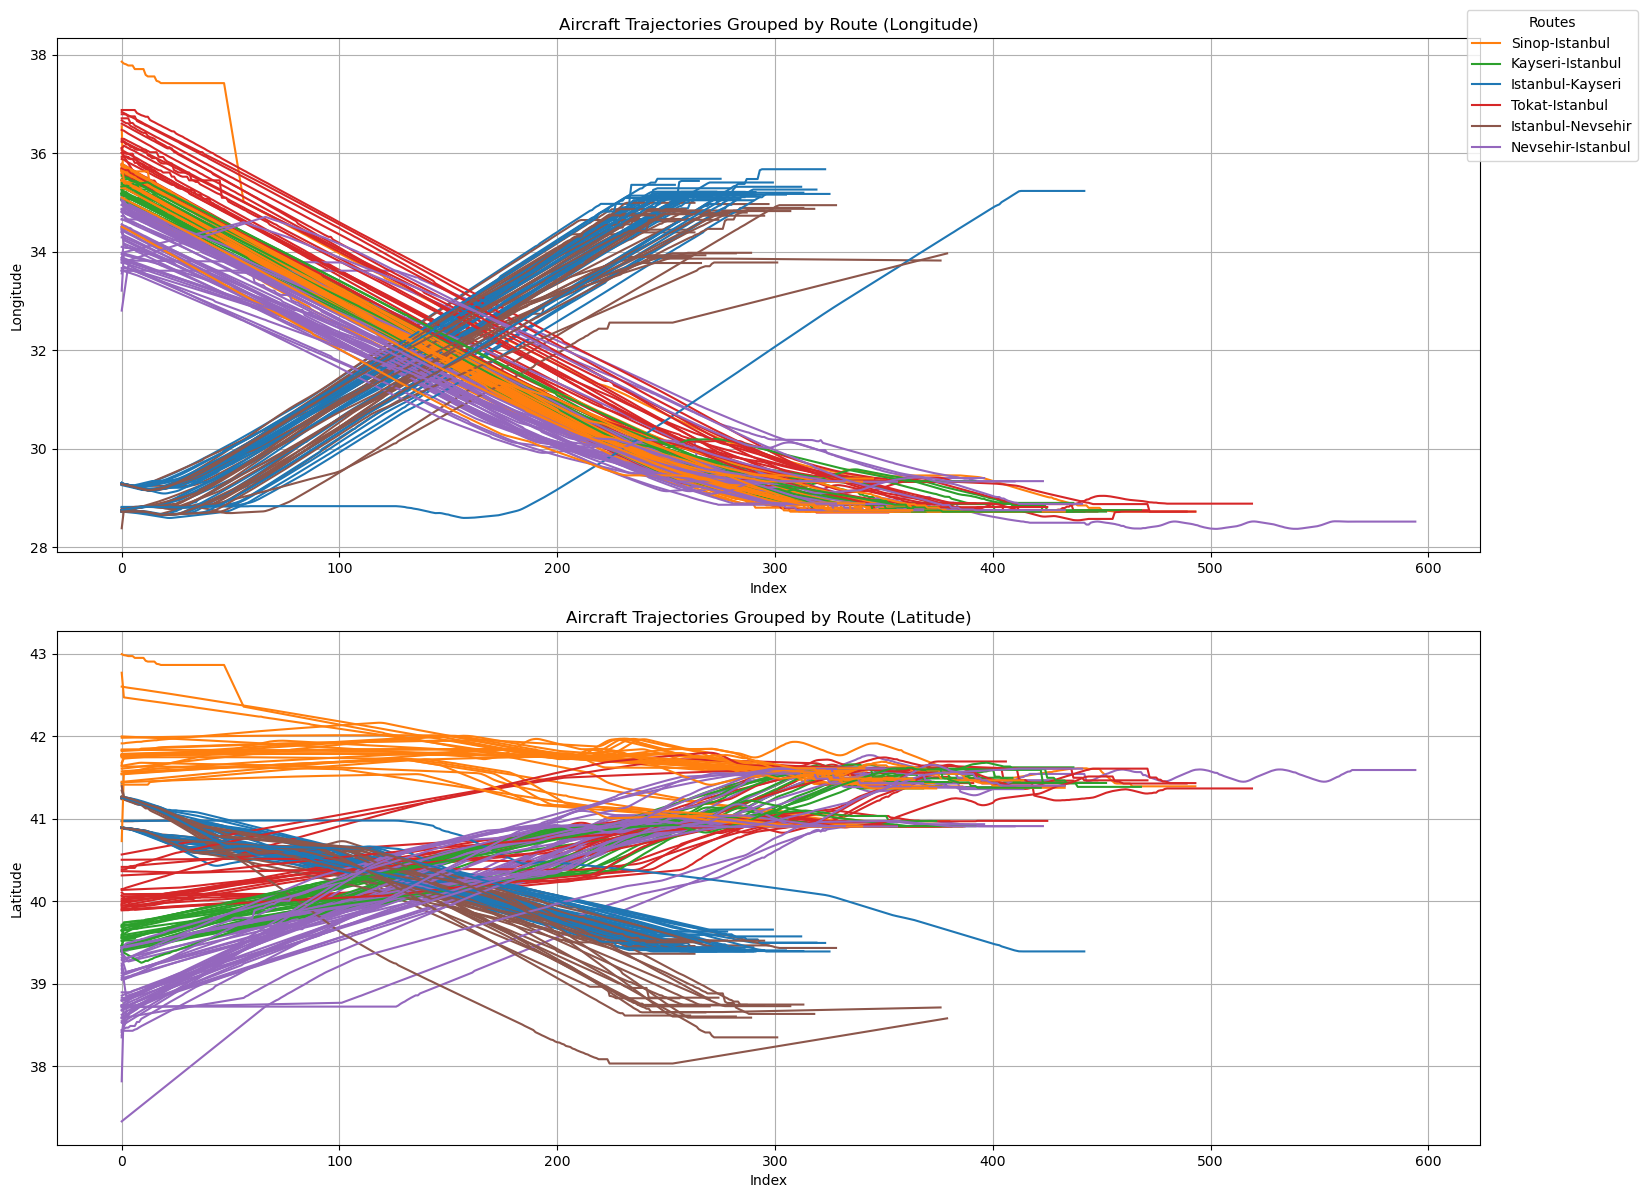

In [28]:
# Define a color map for routes
route_colors = {route: color for route, color in zip(df_select_top['route'].unique(), plt.cm.get_cmap('tab10').colors)}
fig, axs = plt.subplots(2, 1, figsize=(15, 12))
for callsign, group in df_select_top.groupby('callsign_repair'):
    route = group['route'].iloc[0]
    color = route_colors[route]
    group = group.reset_index(drop=False)
    
    # Plot lon_repair
    axs[0].plot(group.index, group['lon_repair'], linestyle='-', label=route, color=color)
    
    # Plot lat_repair
    axs[1].plot(group.index, group['lat_repair'], linestyle='-', label=route, color=color)

# lon_repair plot settings
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Longitude')
axs[0].set_title('Aircraft Trajectories Grouped by Route (Longitude)')
axs[0].grid(True)

# lat_repair plot settings
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Latitude')
axs[1].set_title('Aircraft Trajectories Grouped by Route (Latitude)')
axs[1].grid(True)

# Add legends
handles, labels = axs[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='upper right', title='Routes', bbox_to_anchor=(1.1, 1))

plt.tight_layout()
plt.show()

# Clustering and classification
The routes have similarities since they are close to each other, but we can leverage two features for each route to perform clustering and classification. 

**NOTE**: The TS of the routes have **variable length**

In [29]:
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import dtw
from tslearn.utils import to_time_series_dataset

trajectories = []
trajectories_name = [] # for the class 
for callsign, group in df_select_top.groupby('callsign_repair'):
    trajectory = group[['lat_repair', 'lon_repair']].values
    #trajectory = group[['lon_repair']].values
    trajectories_name.append(group['route'].iloc[0])
    trajectories.append(trajectory)

/home/mirko/miniforge3/envs/timeser3/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [30]:
# Lets build the time series dataset
X = to_time_series_dataset(trajectories) # put NaN as padding
y = trajectories_name

# Normalize the time series
X = TimeSeriesScalerMeanVariance().fit_transform(X)

In [31]:
print(np.unique(y, return_counts=True))
print(X.shape) 

(array(['Istanbul-Kayseri', 'Istanbul-Nevsehir', 'Kayseri-Istanbul',
       'Nevsehir-Istanbul', 'Sinop-Istanbul', 'Tokat-Istanbul'],
      dtype='<U17'), array([39, 34, 29, 46, 32, 22]))
(202, 595, 2)


In [32]:
n_clusters = 3

In [33]:
# Euclidean k-means - DOESNT WORK, different length TS

#kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", random_state=0) 
#kmeans.fit_predict(X)


In [34]:
# DTW k-means

# TAKES LONG 
kmeans_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=5,random_state=0, n_jobs=-1) 
kmeans_dtw.fit_predict(X)
labels = kmeans_dtw.labels_
inertia = kmeans_dtw.inertia_
print(f"Inertia: {inertia}") 

Inertia: 13.032874405516864


In [35]:
labels

array([0, 2, 1, 2, 2, 2, 2, 1, 2, 1, 0, 0, 1, 2, 0, 1, 2, 2, 1, 2, 1, 1,
       1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 0, 1, 1, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 1, 1, 0, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1,
       2, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 1, 2, 2, 1,
       0, 2, 1, 1, 0, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 0, 2, 2, 2, 0,
       2, 1, 0, 2, 1, 1, 0, 1, 0, 1, 2, 0, 0, 0, 1, 2, 1, 2, 2, 1, 1, 1,
       2, 0, 0, 1, 0, 2, 1, 2, 2, 0, 0, 2, 2, 0, 2, 2, 1, 2, 0, 0, 2, 2,
       1, 2, 2, 1, 1, 0, 2, 1, 2, 1, 1, 2, 0, 0, 2, 1, 2, 1, 0, 2, 1, 2,
       2, 1, 2, 0])

In [36]:
sil = silhouette_score(X, labels, metric="dtw", n_jobs=-1) # should be close to 1
print(f"Silhouette score: {sil}")

Silhouette score: 0.8642396050831691


/tmp/ipykernel_735366/2961207838.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10').colors


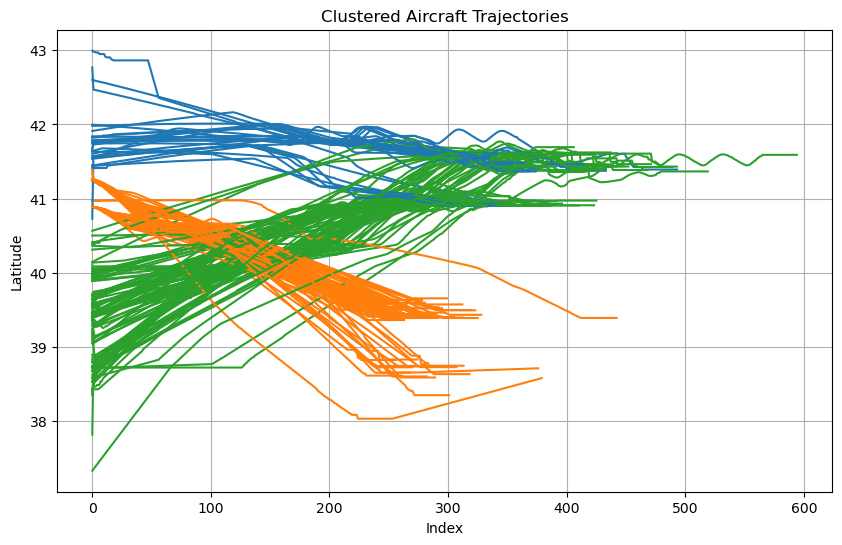

In [37]:
# Plotting the clusters given by the k-means dtw

labels = kmeans_dtw.labels_

plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap('tab10').colors

for i, (callsign, group) in enumerate(df_select_top.groupby('callsign_repair')):
    route = group['route'].iloc[0]
    label = labels[i]
    color = colors[label]
    # index
    group = group.reset_index(drop=False)
    plt.plot(group.index, group['lat_repair'], linestyle='-', label=f'Cluster {label+1}: {route}', color=color)
    #plt.plot(group.index, group['lon_repair'], linestyle='-', label=f'Cluster {label+1}: {route}', color=color)   # try Longitude
plt.xlabel('Index')
plt.ylabel('Latitude')
plt.title('Clustered Aircraft Trajectories')
#plt.legend(loc='best', title='Clusters')
plt.grid(True)
plt.show()

We try also a resampled version of X using TimeSeriesResampler. CAUTION:
- In case we really want to use method that cannot run on variable-length time series
- It introduces temporal distortions in data

In [38]:
from tslearn.preprocessing import TimeSeriesResampler

resampled_X = TimeSeriesResampler(sz=X.shape[1]).fit_transform(X)
resampled_X.shape

(202, 595, 2)

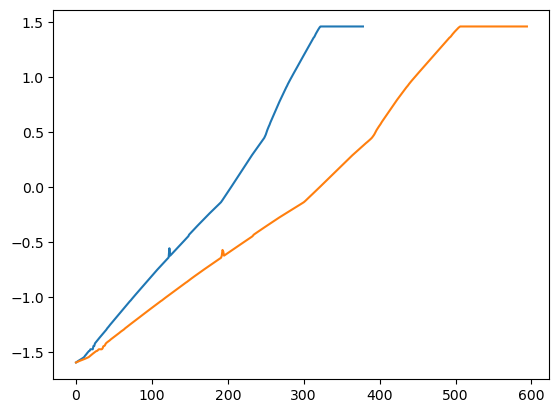

In [39]:
X[5][:,0] # 5 trajectory, 0 is the first dimension (lat)
plt.plot(X[5][:,0])
plt.plot(resampled_X[5][:,0])

In [40]:
# Now can try again Euclidean K-means

print("Try n_clusters", n_clusters)
kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", random_state=0) 
kmeans.fit_predict(resampled_X)
labels = kmeans.labels_
inertia = kmeans.inertia_
print(f"Inertia: {inertia}")

sil = silhouette_score(resampled_X, labels, metric="euclidean") # should be close to 1
print(f"Silhouette score: {sil}")

Try n_clusters 3
Inertia: 39.97311165528747
Silhouette score: 0.8384312873832674


For n_clusters = 2, the inertia is : 266.9840535930618 the average silhouette_score is : 0.7384013771466209
For n_clusters = 3, the inertia is : 39.97311165528747 the average silhouette_score is : 0.8384312873832674
For n_clusters = 4, the inertia is : 34.82281029662874 the average silhouette_score is : 0.572143659503836
For n_clusters = 5, the inertia is : 28.059822030649176 the average silhouette_score is : 0.5305541126002923
For n_clusters = 6, the inertia is : 25.295526370751688 the average silhouette_score is : 0.5088330014938999
For n_clusters = 7, the inertia is : 23.938228131677253 the average silhouette_score is : 0.5087294196307017
For n_clusters = 8, the inertia is : 22.54447243385878 the average silhouette_score is : 0.4617466258905649
For n_clusters = 9, the inertia is : 21.49112291975251 the average silhouette_score is : 0.46114282889765457


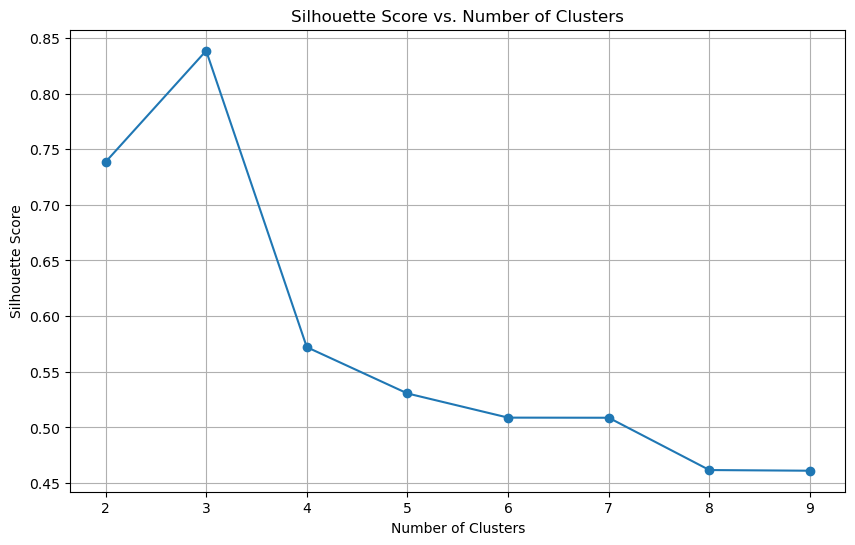

In [41]:
# Evaluate performance for different numbers of clusters
silhouette_scores = []
cluster_range = range(2, 10)

for n_clust in cluster_range:
    kmeans = TimeSeriesKMeans(n_clusters=n_clust, metric="euclidean", random_state=0)
    lab = kmeans.fit_predict(resampled_X)
    silhouette_avg = silhouette_score(resampled_X, lab, metric="euclidean")
    silhouette_scores.append(silhouette_avg)
    iner = kmeans.inertia_
    print(f"For n_clusters = {n_clust}, the inertia is : {iner} the average silhouette_score is : {silhouette_avg}") 

# Plotting Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.show()


### Observations
Three clusters seem to be the best choice for the data, given the similarities in the routes. 

Euclidean K-means with resampled time series also performs well.

### Lets plot the centers

In [42]:
kmeans_dtw.cluster_centers_.shape # 3 clusters, 2 dimensions
# remove one dim 
kmeans_dtw.cluster_centers_[:,:,0].shape

(3, 595)

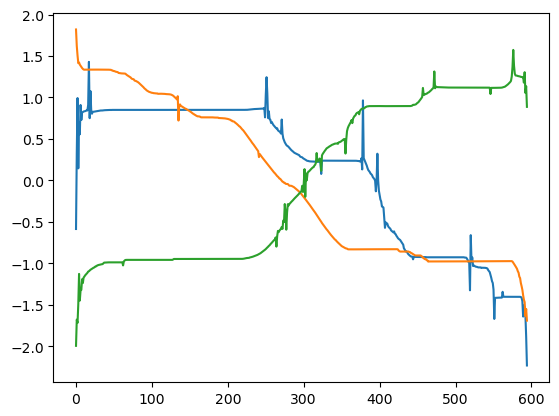

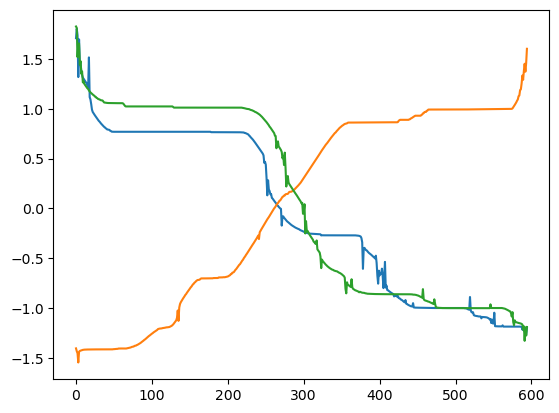

In [43]:
plt.plot(np.squeeze(kmeans_dtw.cluster_centers_[:,:,0]).T) # dim 0 is lat
plt.show()
plt.plot(np.squeeze(kmeans_dtw.cluster_centers_[:,:,1]).T) # dim 1 is lon
plt.show()

## Classification

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.svm import TimeSeriesSVC
#from tslearn.shapelets import LearningShapelets # requires tensorflow

In [45]:
def train_evaluate_clf(X_train, X_test, y_train, y_test, clf, info_print):
    # Split data into train and test sets

    # Fit the classifier
    clf.fit(X_train, y_train)

    # Predict the labels of the test data
    y_pred = clf.predict(X_test)

    # Compute the accuracy and F1 score of the classifier
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print performance metrics and classifier
    print(f"INFO: {info_print}")
    print(f"Accuracy: {accuracy}")
    print(f"F1: {f1}")
    print(classification_report(y_test, y_pred))
    return y_pred

## Time Series Classifcation
- KNeighborsClassifier form pyts is univariate
- we use KNeighborsTimeSeriesClassifier from tslearn that is multivariate

In [46]:
# classification using all dataset

X_train, X_test, y_train, y_test = X, X, y, y
clf = KNeighborsTimeSeriesClassifier(n_neighbors=2, n_jobs=-1) # standard metric is dtw - can use different length TS

y_pred = train_evaluate_clf(X_train, X_test, y_train, y_test, clf, "KNeighborsTimeSeriesClassifier - all dataset")   

INFO: KNeighborsTimeSeriesClassifier - all dataset
Accuracy: 0.8613861386138614
F1: 0.8548510011297654
                   precision    recall  f1-score   support

 Istanbul-Kayseri       0.71      1.00      0.83        39
Istanbul-Nevsehir       1.00      0.53      0.69        34
 Kayseri-Istanbul       0.74      1.00      0.85        29
Nevsehir-Istanbul       0.95      0.91      0.93        46
   Sinop-Istanbul       1.00      1.00      1.00        32
   Tokat-Istanbul       1.00      0.64      0.78        22

         accuracy                           0.86       202
        macro avg       0.90      0.85      0.85       202
     weighted avg       0.90      0.86      0.85       202



In [47]:
# classification with split train test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=0, stratify=y)

clf = KNeighborsTimeSeriesClassifier(n_neighbors=2, n_jobs=-1) # standard metric is dtw - can use different length TS
#clf = TimeSeriesSVC(C=1.0, kernel="gak", n_jobs=-1)           # no NaNs - with resampled_X works bad
#clf = LearningShapelets(n_shapelets_per_size={3: 1})          # require tensorflow


y_pred = train_evaluate_clf(X_train, X_test, y_train, y_test, clf, "KNeighborsTimeSeriesClassifier")

INFO: KNeighborsTimeSeriesClassifier
Accuracy: 0.7887323943661971
F1: 0.7769365040982361
                   precision    recall  f1-score   support

 Istanbul-Kayseri       0.63      0.86      0.73        14
Istanbul-Nevsehir       0.71      0.42      0.53        12
 Kayseri-Istanbul       0.67      0.80      0.73        10
Nevsehir-Istanbul       0.89      1.00      0.94        16
   Sinop-Istanbul       1.00      1.00      1.00        11
   Tokat-Istanbul       1.00      0.50      0.67         8

         accuracy                           0.79        71
        macro avg       0.82      0.76      0.76        71
     weighted avg       0.81      0.79      0.78        71



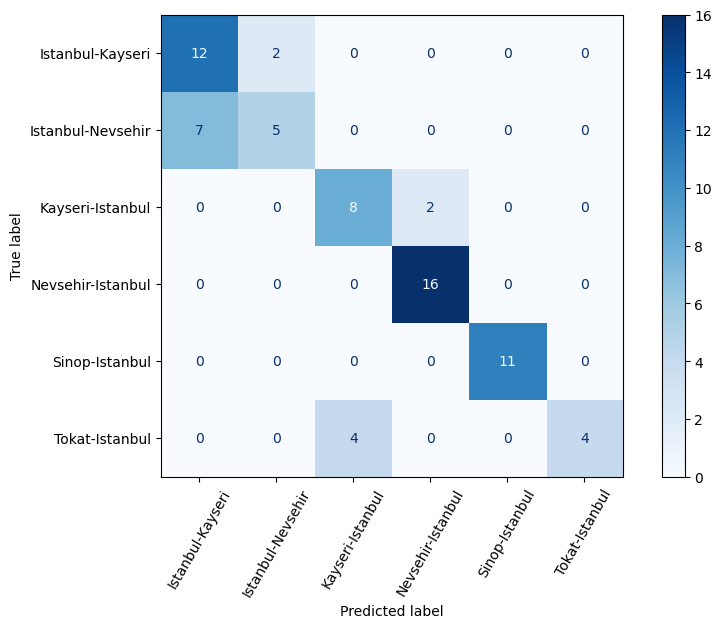

In [48]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_,)
disp.plot(cmap='Blues', xticks_rotation=60, ax=ax)
plt.show()

# Classification using shapelet transform

We will use the shapelet transform to classify the flight routes.
Only univariate TS are supported, so we will use 
- only latitude/longitude data
- PCA to get the principal component that captures the most variance in the data

In [49]:
from pyts.transformation import ShapeletTransform
from sklearn.decomposition import PCA


In [50]:
# need to use resampled_X
resampled_X = TimeSeriesResampler(sz=X.shape[1]).fit_transform(X)

# pca 
pca = PCA(n_components=1)
X_1d = pca.fit_transform(resampled_X.reshape(-1, resampled_X.shape[-1]))
X_1d = X_1d.reshape(resampled_X.shape[0], resampled_X.shape[1])

# lat 
#X_1d = resampled_X[:,:,0] 

# lon 
#X_1d = resampled_X[:,:,1] 

X_1d.shape


(202, 595)

In [51]:
def shapelet_transform(X_1d, y):
    X_train, X_test, y_train, y_test = train_test_split(X_1d, y, test_size=0.35, random_state=0, stratify=y)
    st = ShapeletTransform(window_sizes=[4, 12],
                       n_shapelets='auto', # (default) The number of shapelets to keep. If 'auto', it will be set to  X.shape[0]//2, half the number of timestamps of each TS
                       random_state=42, sort=True, verbose=1, n_jobs = -1) # 4,12 means that the shapelet length will be between 4 and 12



    # Find the n_shapelets best shapelets in the training set and computes the distances between them and the training set.
    X_new = st.fit_transform(X_train, y_train)
    # Computes the distances between the selected shapelets and the samples.
    X_test_new = st.transform(X_test)

    return X_new, X_test_new, y_train, y_test

In [52]:
# we can use a classifier to classify the samples using the distances as features
from sklearn.tree import DecisionTreeClassifier

resampled_X = TimeSeriesResampler(sz=X.shape[1]).fit_transform(X)


X_new, X_test_new, y_train, y_test = shapelet_transform(X_1d, y)
clf = DecisionTreeClassifier(max_depth=8, random_state=42)
y_pred = train_evaluate_clf(X_new, X_test_new, y_train, y_test, clf, "DecisionTreeClassifier_ShapeletTransform -- 1D")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 131 out of 131 | elapsed:  1.6min finished


INFO: DecisionTreeClassifier_ShapeletTransform -- 1D
Accuracy: 0.6338028169014085
F1: 0.6292131876224669
                   precision    recall  f1-score   support

 Istanbul-Kayseri       0.60      0.43      0.50        14
Istanbul-Nevsehir       0.50      0.67      0.57        12
 Kayseri-Istanbul       0.50      0.40      0.44        10
Nevsehir-Istanbul       0.65      0.69      0.67        16
   Sinop-Istanbul       1.00      1.00      1.00        11
   Tokat-Istanbul       0.56      0.62      0.59         8

         accuracy                           0.63        71
        macro avg       0.63      0.63      0.63        71
     weighted avg       0.64      0.63      0.63        71



### Observations: 
- best accuracy using this method is using latitude (slightly better than PCA)
- Latitude is dim 0: 
    - X_1d = resampled_X[:,:,0] 



# Classification Feature-Based


In [53]:
# FEATURE BASED
import scipy.stats as stats
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [54]:
resampled_X = TimeSeriesResampler(sz=X.shape[1]).fit_transform(X)

# pca 
pca = PCA(n_components=1)
X_1d = pca.fit_transform(resampled_X.reshape(-1, resampled_X.shape[-1]))
X_1d = X_1d.reshape(resampled_X.shape[0], resampled_X.shape[1])

# lat
X_1d = resampled_X[:,:,0] 

# lon
# X_1d = resampled_X[:,:,1] 

In [55]:
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X_1d, y, test_size=0.35, random_state=0, stratify=y)

X_train3 = np.array([list(calculate_features(x).values()) for x in X_train])
X_test3 = np.array([list(calculate_features(x).values()) for x in X_test])

clf = DecisionTreeClassifier(max_depth=8, random_state=42)

y_pred = train_evaluate_clf(X_train3, X_test3, y_train, y_test, clf, "DecisionTreeClassifier_Features")


INFO: DecisionTreeClassifier_Features
Accuracy: 0.5774647887323944
F1: 0.5773059837434964
                   precision    recall  f1-score   support

 Istanbul-Kayseri       0.73      0.79      0.76        14
Istanbul-Nevsehir       0.50      0.50      0.50        12
 Kayseri-Istanbul       0.42      0.50      0.45        10
Nevsehir-Istanbul       0.67      0.62      0.65        16
   Sinop-Istanbul       0.56      0.45      0.50        11
   Tokat-Istanbul       0.50      0.50      0.50         8

         accuracy                           0.58        71
        macro avg       0.56      0.56      0.56        71
     weighted avg       0.58      0.58      0.58        71



### Observations:
- Here PCA is better than latitude and longitude.

### Final comments:
- Using a KNeighbors classifier with multivariate DTW, we achieve an accuracy of approximately 0.8 for 6 route classes.
- The routes are more effectively divided into 3 clusters. When using 3 classes, the accuracy significantly improves with all methods.

In [56]:
y_clust = kmeans_dtw.labels_
X_train, X_test, y_train, y_test = train_test_split(X, y_clust, test_size=0.35, random_state=0, stratify=y)

clf = KNeighborsTimeSeriesClassifier(n_neighbors=2, n_jobs=-1) # standard metric is dtw - can use different length TS
#clf = TimeSeriesSVC(C=1.0, kernel="gak", n_jobs=-1)           # no NaNs - with resampled_X works bad
#clf = LearningShapelets(n_shapelets_per_size={3: 1})          # require tensorflow


y_pred = train_evaluate_clf(X_train, X_test, y_train, y_test, clf, "KNeighborsTimeSeriesClassifier")

INFO: KNeighborsTimeSeriesClassifier
Accuracy: 1.0
F1: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        26
           2       1.00      1.00      1.00        34

    accuracy                           1.00        71
   macro avg       1.00      1.00      1.00        71
weighted avg       1.00      1.00      1.00        71

